#Personality Prediction
---

## Different Personalities

<img  src="https://cdn.shopify.com/s/files/1/0100/5392/articles/Mouthpiece_VdayMeyersBriggs1.progressive.jpg?v=1549578121" data-iml="1561547447318" style='width:600px'>

# Overview

1. Introduction to the data and outline goal of the competition
2. Importing the packages and the data
3. Data exploration
4. Data preprocessing
5. Building the Model
6. Prediction


# Introduction

The Myers-Briggs Type Indicator (MBTI) is a psychological assessment tool used to classify people into one of 16 different personality types.  The classification system consists of a four-letter code based on four dimensions, where each letter in the code refers to the predominant trait in each dimension. The four dimensions are:
- **Mind: Introverted (I)** or **Extraverted (E)** which describes the different attitudes people use to direct their energy (i.e. the "inner world" vs. one's "outer world").
- **Energy: Sensing (S)** or **Intuitive (N)** which describes people's method of processing informaton (i.e. paying more attention to the patterns and possibilities seen in the information received vs. information that comes in through the five senses)
- **Nature: Feeling (F)** or **Thinking (T)** which describes people's method for making decisions (i.e. putting more weight on objective principles and impersonal facts vs. personal concerns and the people involved).
- **Tactics: Perceiving (P)** or **Judging (J)** which describes people's orientation to the outside world and the behaviors one exhibits (i.e. preferring a structured and decided lifestyle vs. a more flexible and adaptive lifestyle)


The letters associated with an individual's preferences are combined to get the Myers Briggs personality type.
The goal of the competition is to build and train a model that is capable of predicting labels for each of the four MBTI variables.

### Package Imports

In [244]:


import pandas as pd
import numpy as np
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords



import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS



from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV


from sklearn.metrics import accuracy_score,log_loss
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import make_scorer

import re
import nltk
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.multiclass import OneVsRestClassifier
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [245]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Data

In [246]:
train = pd.read_csv("/content/drive/MyDrive/mbti_1 (1).csv")

# Exploratory Data Analysis (EDA)

In [247]:
# view the data
train.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [248]:
print('Number of rows and columns in train data:{}' .format(train.shape))

Number of rows and columns in train data:(8675, 2)


#### Is there any missing data in any of the columns?

In [249]:
train.isnull().sum()

type     0
posts    0
dtype: int64

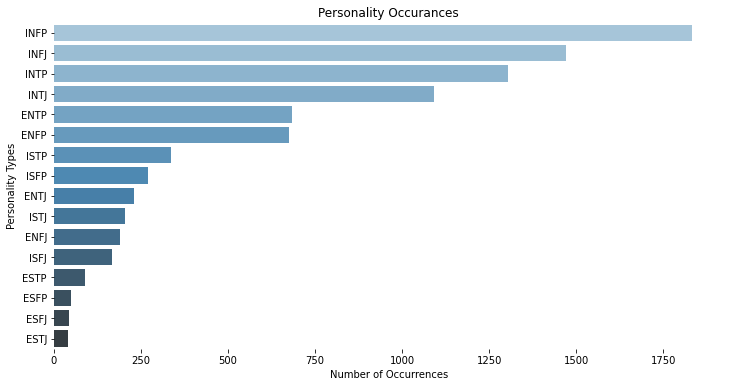

In [250]:
num_c = train['type'].value_counts()
f, ax = plt.subplots(figsize=(12,6))
sns.barplot( num_c.values, num_c.index, palette="Blues_d")
ax.xaxis.grid(False)
ax.set(xlabel="Number of Occurrences")
ax.set(ylabel="Personality Types")
ax.set(title="Personality Occurances")
sns.despine(trim=True, left=True, bottom=True)

#### How many posts were written by each personality type?

In [251]:
type_sum = train.groupby(['type']).count()
type_sum.sort_values('posts', ascending=False, inplace=True)
type_sum

,posts
type,
INFP,1832
INFJ,1470
INTP,1304
INTJ,1091
ENTP,685
ENFP,675
ISTP,337
ISFP,271
ENTJ,231


#### Total words written by each personality type

In [252]:
train['word_count'] = train['posts'].apply(lambda x: len(str(x).split(" ")))
word_count = train.groupby('type').sum()
word_count.sort_values('word_count', ascending=False, inplace=True)
word_count

,word_count
type,
INFP,2346749
INFJ,1935518
INTP,1606399
INTJ,1343332
ENFP,876141
ENTP,850974
ISTP,404616
ISFP,316165
ENTJ,290309


In [253]:
train = train.drop(['word_count'], axis=1)

While the "INFP" personality wrote the most posts and  wrote the most words in their posts.The personality that wrote the least posts was 'ESTJ' and the personality with the least written words was 'ESFP'. 

#### Distribution of the Personality Types

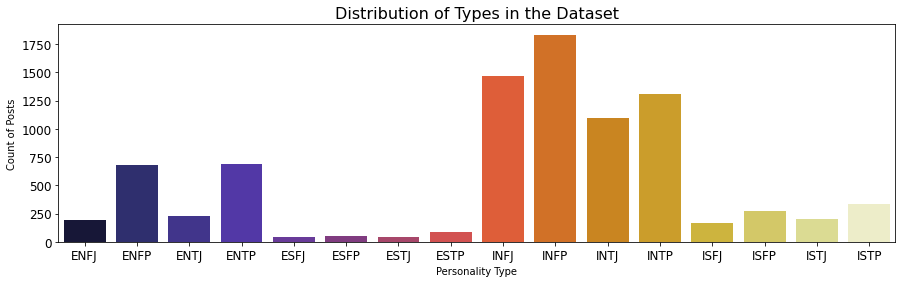

In [254]:
dim = (15.0, 4.0)
fig, ax = plt.subplots(figsize=dim)
cmrmap = sns.color_palette('CMRmap', 16)
sns.set_palette(cmrmap)
sns.countplot(x='type', data=train,
              order=['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP', 'ESTJ',
                     'ESTP', 'INFJ', 'INFP', 'INTJ', 'INTP', 'ISFJ', 'ISFP',
                     'ISTJ', 'ISTP'])
plt.title('Distribution of Types in the Dataset', fontsize=16)
plt.xlabel('Personality Type')
plt.ylabel('Count of Posts')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

The 'ES' personality types have the least posts, whilst the 'IN' personalities have the most posts. This suggests that the data is imbalanced.

In [255]:
# Create a binary column for each of the 4 dimension types
train['Mind'] = train['type'].map(lambda x: 'Extroverted'
                                  if x[0] == 'E' else 'Introverted')
train['Energy'] = train['type'].map(lambda x: 'Intuitive'
                                    if x[1] == 'N' else 'Sensing')
train['Nature'] = train['type'].map(lambda x: 'Thinking'
                                    if x[2] == 'T' else 'Feeling')
train['Tactics'] = train['type'].map(lambda x: 'Judging'
                                     if x[3] == 'J' else 'Perceiving')

### Mind

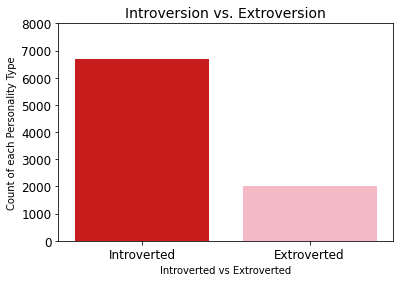

In [256]:
# Countplot of the Introverted - Extroverted variable
IEcolors = sns.xkcd_palette(['red', 'soft pink'])
sns.set_palette(IEcolors)
sns.countplot(x='Mind', data=train, order=['Introverted', 'Extroverted'])
plt.ylim(0, 8000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Introverted vs Extroverted')
plt.ylabel('Count of each Personality Type')
plt.title('Introversion vs. Extroversion', fontsize=14)
plt.show()


There are more introverts who have written posts compare to extroverts. Now let's assess the most common words spoken by each.

In [257]:

def generate_wordcloud(text, title):
    # Create and generate a word cloud image:
    wordcloud = WordCloud(background_color='white').generate(text)

    # Displaying the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=40)
    plt.show()

In [258]:
# Group together posts written by those under the mind variable
words_of_mind = train.groupby('Mind')['posts'].apply(' '.join).reset_index()

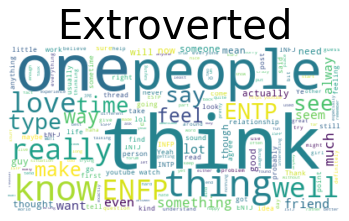

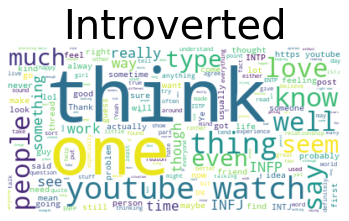

In [259]:
for i, t in enumerate(words_of_mind['Mind']):
    text = words_of_mind.iloc[i,1]
    generate_wordcloud(text, t)

### Energy

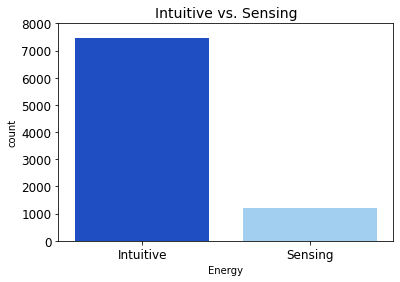

In [260]:
# Countplot of the Intuitive - Sensing variable
NScolors = sns.xkcd_palette(['blue', 'light blue'])
sns.set_palette(NScolors)
sns.countplot(x='Energy', data=train, order=['Intuitive', 'Sensing'])
plt.title('Intuitive vs. Sensing', fontsize=14)
plt.ylim(0, 8000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

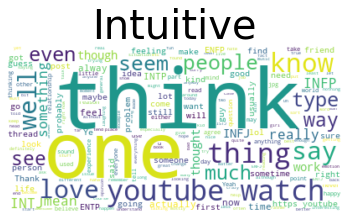

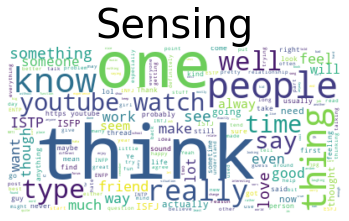

In [261]:
words_of_energy = train.groupby('Energy')['posts'].apply(' '.join).reset_index()
for i, t in enumerate(words_of_energy['Energy']):
    text = words_of_energy.iloc[i, 1]
    generate_wordcloud(text, t)

### Nature

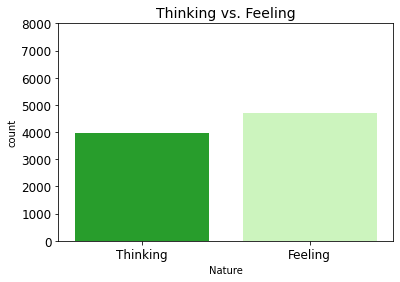

In [262]:
# Countplot of the Tinking - Feeling variable
TFcolors = sns.xkcd_palette(['green', 'pale green'])
sns.set_palette(TFcolors)
sns.countplot(x='Nature', data=train, order=['Thinking', 'Feeling'])
plt.title('Thinking vs. Feeling', fontsize=14)
plt.ylim(0, 8000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

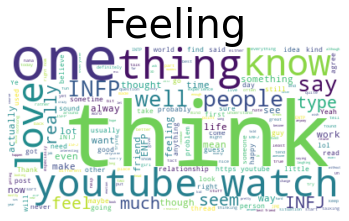

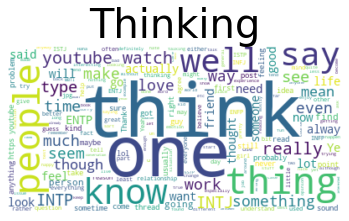

In [263]:
words_of_nature = train.groupby('Nature')['posts'].apply(' '.join).reset_index()
for i, t in enumerate(words_of_nature['Nature']):
    text = words_of_nature.iloc[i, 1]
    generate_wordcloud(text, t)

### Tactics

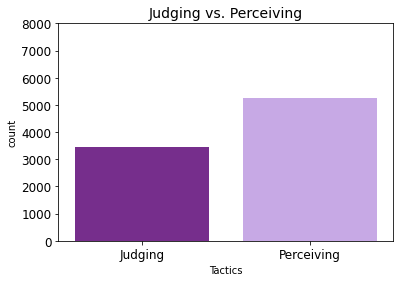

In [264]:
# Countplot of Judging - Perceiving
JPcolors = sns.xkcd_palette(['purple', 'lavender'])
sns.set_palette(JPcolors)
sns.countplot(x='Tactics', data=train, order=['Judging', 'Perceiving'])
plt.title('Judging vs. Perceiving', fontsize=14)
plt.ylim(0, 8000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

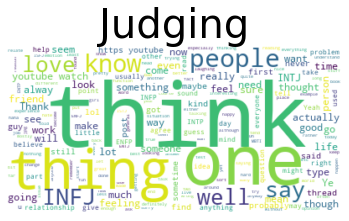

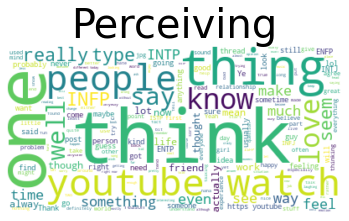

In [265]:
words_of_tactics = train.groupby('Tactics')['posts'].apply(' '.join).reset_index()
for i, t in enumerate(words_of_tactics['Tactics']):
    text = words_of_tactics.iloc[i, 1]
    generate_wordcloud(text, t)

The 'Nature' variable containing 'Thinking - Feeling' is more balanced compared to other variables. 

The word that seems to appear the most among all the personalities is the word 'think'.

# Data Preprocessing

The data has to be preprocessed with the purpose of removing noise, which negatively affects the accuracy of the model, train data is processed

#### Removing delimeters

Each person's posts were made up of 50 individual posts which were separated by  the string '|||'. There was an attempt to split the data,converting each post into the 50 individual posts, with the goal of increasing the size of the dataset (especially those personalities with very few posts). However this method reduced the accuracy  of the model and was abandoned. We therefore removed the delimiters as part of the preprocessing. 

In [266]:
def remove_delimiters (post):
    new = post.replace('|||',' ')
    return ' '.join(new.split())

train['posts'] = train['posts'].apply(remove_delimiters)


#### Removing URLs

Urls don't add any value when analyzing text therefore they were removed

In [267]:

pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r'url-web'
train['posts'] = train['posts'].replace(to_replace = pattern_url, value = subs_url, regex = True)

#### Convert words to lowercase

Words were converted to lowercase in order to remove noise from capitalisation and to avoid having multiple copies of the same words

In [268]:
train['posts'] = train['posts'].str.lower()

#### Remove punctuation and numbers 

Punctuation doesn’t add any extra information to the text data therefore removing it will help reduce the size of the training data.

In [269]:
def remove_punctuation(post):
    punc_numbers = string.punctuation + '0123456789'
    return ''.join([l for l in post if l not in punc_numbers])

train['posts'] = train['posts'].apply(remove_punctuation)

In [270]:
train.head()

,type,posts,Mind,Energy,Nature,Tactics
0,INFJ,urlweb urlweb enfp and intj moments urlweb spo...,Introverted,Intuitive,Feeling,Judging
1,ENTP,im finding the lack of me in these posts very ...,Extroverted,Intuitive,Thinking,Perceiving
2,INTP,good one urlweb of course to which i say i kn...,Introverted,Intuitive,Thinking,Perceiving
3,INTJ,dear intp i enjoyed our conversation the other...,Introverted,Intuitive,Thinking,Judging
4,ENTJ,youre fired thats another silly misconception ...,Extroverted,Intuitive,Thinking,Judging


#### Lemmatization

The words in the dataset were also lemmatized.Lemmatization  returns the base or dictionary form of a word, which is known as the lemma.Lemmatization is considered to be better than stemming because lemmatization returns an actual word of the language, and is used when it is necessary to get valid words.

In [271]:
# Lematise posts
import nltk
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
train['lemma'] = [' '.join([lemmatizer.lemmatize(word) for word in text.split(' ')])for text in train['posts']]


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [272]:
train

,type,posts,Mind,Energy,Nature,Tactics,lemma
0,INFJ,urlweb urlweb enfp and intj moments urlweb spo...,Introverted,Intuitive,Feeling,Judging,urlweb urlweb enfp and intj moment urlweb spor...
1,ENTP,im finding the lack of me in these posts very ...,Extroverted,Intuitive,Thinking,Perceiving,im finding the lack of me in these post very a...
2,INTP,good one urlweb of course to which i say i kn...,Introverted,Intuitive,Thinking,Perceiving,good one urlweb of course to which i say i kn...
3,INTJ,dear intp i enjoyed our conversation the other...,Introverted,Intuitive,Thinking,Judging,dear intp i enjoyed our conversation the other...
4,ENTJ,youre fired thats another silly misconception ...,Extroverted,Intuitive,Thinking,Judging,youre fired thats another silly misconception ...
...,...,...,...,...,...,...,...
8670,ISFP,urlweb ixfp just because i always think of cat...,Introverted,Sensing,Feeling,Perceiving,urlweb ixfp just because i always think of cat...
8671,ENFP,soif this thread already exists someplace else...,Extroverted,Intuitive,Feeling,Perceiving,soif this thread already exists someplace else...
8672,INTP,so many questions when i do these things i wou...,Introverted,Intuitive,Thinking,Perceiving,so many question when i do these thing i would...
8673,INFP,i am very conflicted right now when it comes t...,Introverted,Intuitive,Feeling,Perceiving,i am very conflicted right now when it come to...


#### Checking for stopwords in the text

In [273]:
#Check for stopwords train
import nltk
nltk.download('stopwords')
stop = stopwords.words('english')
train['stopwords'] = train['lemma'].apply(lambda x: len([x for x in x.split() if x in stop]))
train[['lemma','stopwords']].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,lemma,stopwords
0,urlweb urlweb enfp and intj moment urlweb spor...,257
1,im finding the lack of me in these post very a...,587
2,good one urlweb of course to which i say i kn...,402
3,dear intp i enjoyed our conversation the other...,529
4,youre fired thats another silly misconception ...,495


In [274]:
#Check for stopwords test
stop = stopwords.words('english')

Stopwords tend to have a negative influence over the accuracy of a model ,therefore these will need to be removed. This will be done by vectorizer in the model building section,TfidfVectorizer has the ability of removing stopwords.

In [275]:
def remove_stop_words(word):
    if word not in stop:
        return word
    else:
        return ''

# Model Building

This require classification machine learning techniques.

Initially a multi-class classification approach was taken, in which the model would use the input data to predict each row of input as one of the 16 personality types. The results were not very good and this lead to the change in approach where each of the individual personality characteristics 'mind', 'energy', 'nature' & 'tactics' were classified separately as binary classification problems.

Various classification techniques were applied to the data
- Logistic Regression
- Multinomial Naive Bayes
- Support Vector Classifier (SVC)
- Random Forrest Classifier

vectorizers were used
- TfidfVectorizer

The code used for Logistic Regression with TfidfVectorizer follows in this notebook.



In [276]:

train['E'] = train['type'].apply(lambda x: x[0] == 'E').astype('int')
train['N'] = train['type'].apply(lambda x: x[1] == 'N').astype('int')
train['T'] = train['type'].apply(lambda x: x[2] == 'T').astype('int')
train['J'] = train['type'].apply(lambda x: x[3] == 'J').astype('int')

In [277]:
train.head()

,type,posts,Mind,Energy,Nature,Tactics,lemma,stopwords,E,N,T,J
0,INFJ,urlweb urlweb enfp and intj moments urlweb spo...,Introverted,Intuitive,Feeling,Judging,urlweb urlweb enfp and intj moment urlweb spor...,257,0,1,0,1
1,ENTP,im finding the lack of me in these posts very ...,Extroverted,Intuitive,Thinking,Perceiving,im finding the lack of me in these post very a...,587,1,1,1,0
2,INTP,good one urlweb of course to which i say i kn...,Introverted,Intuitive,Thinking,Perceiving,good one urlweb of course to which i say i kn...,402,0,1,1,0
3,INTJ,dear intp i enjoyed our conversation the other...,Introverted,Intuitive,Thinking,Judging,dear intp i enjoyed our conversation the other...,529,0,1,1,1
4,ENTJ,youre fired thats another silly misconception ...,Extroverted,Intuitive,Thinking,Judging,youre fired thats another silly misconception ...,495,1,1,1,1


###Mind model

In [278]:
mind_df = train[['lemma','E']]

Vectorise the words with TfidfVectorizer

Several iterations of parameters were applied for each characteritic.

For Mind classification the best log loss result was achieved with below parameters
- max_features = 250 (this parmeter that was adjusted the most when tuning)
- min_df = 4 (had very little effect, when using the max_features the lower frequency words aren't selected)
- max_df = 0.5 (consistently produced the better results with a 0.5 setting)

In [279]:
vect_mind = TfidfVectorizer(lowercase=True, 
                            stop_words='english', 
                            max_features=250,
                            min_df=4,
                            max_df=0.5
                           )

In [280]:
vect_mind.fit(mind_df['lemma'])
X_count_mind = vect_mind.transform(mind_df['lemma'])

In [281]:
X_count_mind.shape

(8675, 250)

In [282]:
vect_mind.get_feature_names()

['able',
 'absolutely',
 'act',
 'advice',
 'age',
 'ago',
 'agree',
 'answer',
 'arent',
 'ask',
 'away',
 'awesome',
 'bad',
 'based',
 'believe',
 'big',
 'bit',
 'book',
 'called',
 'came',
 'care',
 'case',
 'cause',
 'certain',
 'change',
 'character',
 'child',
 'class',
 'close',
 'college',
 'common',
 'completely',
 'consider',
 'conversation',
 'cool',
 'couple',
 'course',
 'crazy',
 'dad',
 'definitely',
 'depends',
 'description',
 'difference',
 'dream',
 'easy',
 'emotion',
 'emotional',
 'end',
 'enfj',
 'enfp',
 'enfps',
 'enjoy',
 'entj',
 'entp',
 'esfj',
 'esfp',
 'especially',
 'estp',
 'exactly',
 'example',
 'experience',
 'eye',
 'face',
 'fact',
 'family',
 'far',
 'favorite',
 'fe',
 'felt',
 'female',
 'fi',
 'figure',
 'fit',
 'forum',
 'fun',
 'function',
 'funny',
 'game',
 'general',
 'generally',
 'getting',
 'girl',
 'god',
 'great',
 'group',
 'guess',
 'haha',
 'hand',
 'happy',
 'hate',
 'havent',
 'having',
 'head',
 'hear',
 'heard',
 'heart',
 'h

In [283]:
X = X_count_mind
y = mind_df['E']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size =0.3,
                                                   random_state = 42)

In [284]:
def scoring_function_log_loss(y_test, y_pred_test):
    return log_loss(y_test, y_pred_test)

In [285]:
score_log_loss = make_scorer(scoring_function_log_loss, greater_is_better = False)

In [286]:
def tune_LogReg_model(X_train, y_train): 
    C_list = [0.001, 0.01, 0.1, 0.5, 0.75, 1, 5, 10, 25, 100]
    penalty_list = ['l1','l2']

    score = make_scorer(scoring_function_log_loss, greater_is_better = False)
    
    logreg = LogisticRegression()
    
    parameters = {'C':C_list,
                  'penalty': penalty_list}
    tune = GridSearchCV(logreg, parameters, scoring = score)
    tune.fit(X_train,y_train)
    
    return tune

In [287]:
best_mind_model = tune_LogReg_model(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solve

In [288]:
best_mind_model.best_params_

{'C': 5, 'penalty': 'l2'}

In [289]:
mind_model = LogisticRegression(C=best_mind_model.best_params_['C'], penalty = best_mind_model.best_params_['penalty'])
mind_model.fit(X_train, y_train)

LogisticRegression(C=5)

In [290]:
y_pred_train = mind_model.predict(X_train)

In [291]:
y_pred_test = mind_model.predict(X_test)

In [292]:
accuracy_score(y_test, y_pred_test)

0.8586246638494045

In [293]:
accuracy_score(y_train, y_pred_train)

0.8679183135704874

In [294]:
confusion_matrix(y_train, y_pred_train)

array([[4437,  208],
       [ 594,  833]])

In [295]:
confusion_matrix(y_test, y_pred_test)

array([[1918,  113],
       [ 255,  317]])

In [296]:
log_loss(y_train, y_pred_train)

4.56196722414095

In [297]:
log_loss(y_test, y_pred_test)

4.882965834743275

In [298]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      4645
           1       0.80      0.58      0.68      1427

    accuracy                           0.87      6072
   macro avg       0.84      0.77      0.80      6072
weighted avg       0.86      0.87      0.86      6072



In [299]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      2031
           1       0.74      0.55      0.63       572

    accuracy                           0.86      2603
   macro avg       0.81      0.75      0.77      2603
weighted avg       0.85      0.86      0.85      2603



In [300]:
mind_log_loss = cross_val_score(mind_model, X, y, scoring=score_log_loss,cv=4,)
print('Log Loss %2f' %(-1 * mind_log_loss.mean()))

mind_acc = cross_val_score(mind_model, X, y, scoring='accuracy',cv=4,)
print('Accuracy %2f' %(mind_acc.mean()))

Log Loss 5.048460
Accuracy 0.853833


### Energy model

In [301]:
energy_df = train[['lemma','N']]

In [302]:
vect_energy = TfidfVectorizer(lowercase=True, 
                            stop_words='english', 
                            max_features=195,
                            min_df=4,
                            max_df=0.5
                           )
vect_energy.fit(energy_df['lemma'])
X_count_energy = vect_energy.transform(energy_df['lemma'])

X_count_energy.shape

vect_energy.get_feature_names()

['able',
 'advice',
 'ago',
 'agree',
 'answer',
 'arent',
 'ask',
 'away',
 'awesome',
 'bad',
 'based',
 'believe',
 'big',
 'bit',
 'book',
 'came',
 'care',
 'case',
 'certain',
 'change',
 'character',
 'child',
 'class',
 'close',
 'completely',
 'conversation',
 'cool',
 'couple',
 'course',
 'crazy',
 'definitely',
 'dream',
 'emotion',
 'emotional',
 'end',
 'enfj',
 'enfp',
 'enjoy',
 'entj',
 'entp',
 'esfj',
 'especially',
 'estp',
 'exactly',
 'example',
 'experience',
 'eye',
 'face',
 'fact',
 'family',
 'far',
 'favorite',
 'fe',
 'felt',
 'female',
 'fi',
 'fit',
 'forum',
 'fun',
 'function',
 'funny',
 'game',
 'general',
 'getting',
 'girl',
 'god',
 'great',
 'group',
 'guess',
 'haha',
 'happy',
 'hate',
 'havent',
 'having',
 'head',
 'hear',
 'hey',
 'hi',
 'high',
 'home',
 'hope',
 'hour',
 'human',
 'important',
 'infj',
 'infjs',
 'infp',
 'infps',
 'interested',
 'interesting',
 'intj',
 'intjs',
 'intp',
 'intps',
 'isfj',
 'isfp',
 'isnt',
 'issue',
 'ist

In [303]:
X = X_count_energy
y = energy_df['N']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size =0.3,
                                                   random_state = 42)

In [304]:
best_energy_model = tune_LogReg_model(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solve

In [305]:
best_energy_model.best_params_

{'C': 25, 'penalty': 'l2'}

In [306]:
energy_model = LogisticRegression(C=best_energy_model.best_params_['C'], penalty = best_energy_model.best_params_['penalty'])
energy_model.fit(X_train, y_train)

LogisticRegression(C=25)

In [307]:
y_pred_train = energy_model.predict(X_train)

accuracy_score(y_train, y_pred_train)

0.9067852437417655

In [308]:
y_pred_test = energy_model.predict(X_test)

accuracy_score(y_test, y_pred_test)

0.9020361121782559

In [309]:
confusion_matrix(y_train, y_pred_train)

array([[ 380,  440],
       [ 126, 5126]])

In [310]:
confusion_matrix(y_test, y_pred_test)

array([[ 164,  213],
       [  42, 2184]])

In [311]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.75      0.46      0.57       820
           1       0.92      0.98      0.95      5252

    accuracy                           0.91      6072
   macro avg       0.84      0.72      0.76      6072
weighted avg       0.90      0.91      0.90      6072



In [312]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.80      0.44      0.56       377
           1       0.91      0.98      0.94      2226

    accuracy                           0.90      2603
   macro avg       0.85      0.71      0.75      2603
weighted avg       0.89      0.90      0.89      2603



In [313]:
log_loss(y_train, y_pred_train)

3.2195815649520325

In [314]:
log_loss(y_test, y_pred_test)

3.3836182462369795

In [315]:
energy_log_loss = cross_val_score(energy_model, X, y, scoring=score_log_loss,cv=4)
print('Log Loss %2f' %(-1 * energy_log_loss.mean()))

energy_acc = cross_val_score(energy_model, X, y, scoring='accuracy',cv=4,)
print('Accuracy %2f' %(energy_acc.mean()))

Log Loss 3.491762
Accuracy 0.898905


### Nature model

In [316]:
nature_df = train[['lemma','T']]

In [317]:
vect_nature = TfidfVectorizer(lowercase=True, 
                            stop_words='english', 
                            max_features=3900,
                            min_df=4,
                            max_df=0.5
                            #ngram_range=(3,3)
                           )
vect_nature.fit(nature_df['lemma'])
X_count_nature = vect_nature.transform(nature_df['lemma'])

X_count_nature.shape

vect_nature.get_feature_names()

['ability',
 'able',
 'absolute',
 'absolutely',
 'absorbed',
 'abstract',
 'absurd',
 'abuse',
 'abusive',
 'academic',
 'accent',
 'accept',
 'acceptable',
 'acceptance',
 'accepted',
 'accepting',
 'access',
 'accident',
 'accidentally',
 'accomplish',
 'accomplished',
 'according',
 'account',
 'accuracy',
 'accurate',
 'accurately',
 'accused',
 'achieve',
 'achievement',
 'acknowledge',
 'acquaintance',
 'act',
 'acted',
 'acting',
 'action',
 'active',
 'actively',
 'activity',
 'actor',
 'actual',
 'ad',
 'adam',
 'adapt',
 'add',
 'added',
 'addicted',
 'addiction',
 'adding',
 'addition',
 'address',
 'adhd',
 'admire',
 'admit',
 'admittedly',
 'adorable',
 'adore',
 'adult',
 'advance',
 'advanced',
 'advantage',
 'adventure',
 'adventurous',
 'advice',
 'advise',
 'advocate',
 'aesthetic',
 'affect',
 'affected',
 'affection',
 'affectionate',
 'affirmation',
 'afford',
 'afraid',
 'afternoon',
 'age',
 'agenda',
 'aggressive',
 'agnostic',
 'ago',
 'agree',
 'agreed',
 'a

In [318]:
X = X_count_nature
y = nature_df['T']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size =0.3,
                                                   random_state = 42)

In [319]:
best_nature_model = tune_LogReg_model(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [320]:
best_nature_model.best_params_

{'C': 0.5, 'penalty': 'l2'}

In [321]:
nature_model = LogisticRegression(C=best_nature_model.best_params_['C'], penalty = best_nature_model.best_params_['penalty'])
nature_model.fit(X_train, y_train)

LogisticRegression(C=0.5)

In [322]:
y_pred_train = nature_model.predict(X_train)

accuracy_score(y_train, y_pred_train)

0.9018445322793149

In [323]:
y_pred_test = nature_model.predict(X_test)

accuracy_score(y_test, y_pred_test)

0.8486361890126777

In [324]:
confusion_matrix(y_train, y_pred_train)

array([[2995,  283],
       [ 313, 2481]])

In [325]:
confusion_matrix(y_test, y_pred_test)

array([[1225,  191],
       [ 203,  984]])

In [326]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      3278
           1       0.90      0.89      0.89      2794

    accuracy                           0.90      6072
   macro avg       0.90      0.90      0.90      6072
weighted avg       0.90      0.90      0.90      6072



In [327]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.86      0.87      0.86      1416
           1       0.84      0.83      0.83      1187

    accuracy                           0.85      2603
   macro avg       0.85      0.85      0.85      2603
weighted avg       0.85      0.85      0.85      2603



In [328]:
log_loss(y_train, y_pred_train)

3.390207018682397

In [329]:
log_loss(y_test, y_pred_test)

5.227979493931609

In [330]:
nature_log_loss = cross_val_score(nature_model, X, y, scoring=score_log_loss,cv=4,)
print('Log Loss %2f' %(-1 * nature_log_loss.mean()))

nature_acc = cross_val_score(nature_model, X, y, scoring='accuracy',cv=4,)
print('Accuracy %2f' %(nature_acc.mean()))

Log Loss 4.813591
Accuracy 0.860634


### Tactics model

In [331]:
tactics_df = train[['lemma','J']]

In [332]:
vect_tactics = TfidfVectorizer(lowercase=True, 
                            stop_words='english', 
                            max_features=260,
                            min_df=4,
                            max_df=0.5
                           )
vect_tactics.fit(tactics_df['lemma'])
X_count_tactics = vect_tactics.transform(tactics_df['lemma'])

X_count_tactics.shape

vect_tactics.get_feature_names()

['able',
 'absolutely',
 'act',
 'advice',
 'age',
 'ago',
 'agree',
 'answer',
 'arent',
 'ask',
 'away',
 'awesome',
 'bad',
 'based',
 'believe',
 'big',
 'bit',
 'book',
 'called',
 'came',
 'care',
 'case',
 'cause',
 'certain',
 'change',
 'character',
 'child',
 'class',
 'close',
 'college',
 'common',
 'completely',
 'consider',
 'conversation',
 'cool',
 'couple',
 'course',
 'crazy',
 'dad',
 'deal',
 'definitely',
 'depends',
 'description',
 'difference',
 'difficult',
 'dream',
 'easy',
 'emotion',
 'emotional',
 'end',
 'enfj',
 'enfp',
 'enfps',
 'enjoy',
 'entj',
 'entp',
 'entps',
 'esfj',
 'esfp',
 'especially',
 'estp',
 'exactly',
 'example',
 'experience',
 'eye',
 'face',
 'fact',
 'family',
 'far',
 'favorite',
 'fe',
 'felt',
 'female',
 'fi',
 'figure',
 'fit',
 'forum',
 'fun',
 'function',
 'funny',
 'game',
 'general',
 'generally',
 'getting',
 'girl',
 'god',
 'great',
 'group',
 'guess',
 'haha',
 'hand',
 'happy',
 'hate',
 'havent',
 'having',
 'head',

In [333]:
X = X_count_tactics
y = tactics_df['J']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size =0.3,
                                                   random_state = 42)

In [334]:
best_tactics_model = tune_LogReg_model(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solve

In [335]:
best_tactics_model.best_params_

{'C': 0.75, 'penalty': 'l2'}

In [336]:
tactics_model = LogisticRegression(C=best_tactics_model.best_params_['C'], penalty = best_tactics_model.best_params_['penalty'])
tactics_model.fit(X_train, y_train)

LogisticRegression(C=0.75)

In [337]:
y_pred_train = tactics_model.predict(X_train)

accuracy_score(y_train, y_pred_train)

0.8170289855072463

In [338]:
y_pred_test = tactics_model.predict(X_test)

accuracy_score(y_test, y_pred_test)

0.7990779869381482

In [339]:
confusion_matrix(y_train, y_pred_train)

array([[3305,  350],
       [ 761, 1656]])

In [340]:
confusion_matrix(y_test, y_pred_test)

array([[1426,  160],
       [ 363,  654]])

In [341]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.81      0.90      0.86      3655
           1       0.83      0.69      0.75      2417

    accuracy                           0.82      6072
   macro avg       0.82      0.79      0.80      6072
weighted avg       0.82      0.82      0.81      6072



In [342]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.80      0.90      0.85      1586
           1       0.80      0.64      0.71      1017

    accuracy                           0.80      2603
   macro avg       0.80      0.77      0.78      2603
weighted avg       0.80      0.80      0.79      2603



In [343]:
log_loss(y_train, y_pred_train)

6.31964104641738

In [344]:
log_loss(y_test, y_pred_test)

6.9396496312436105

In [345]:
tactics_log_loss = cross_val_score(tactics_model, X, y, scoring=score_log_loss,cv=4,)
print('Log Loss %2f' %(-1 * tactics_log_loss.mean()))

tactics_acc = cross_val_score(tactics_model, X, y, scoring='accuracy',cv=4,)
print('Accuracy %2f' %(tactics_acc.mean()))

Log Loss 6.844138
Accuracy 0.801843


### Model conclusions

Of the models that were applied the best result was achieved with LogisticRegression with TfidfVectorizer. SVC with CountVectorizer a very close second. MutlinomialNB & RandomForest performance was poor in comparison to these two.

| Model               | Mind Log Loss | Energy Log Loss | Nature Log Loss | Tactics Log Loss | Average Log Loss | 
|---------------------|---------------|-----------------|-----------------|------------------|------------------
| Logistic Regression |     4.87      |      3.59       |      4.89       |       6.56       |       4.98       


# Predicting on test data

The 4 characteristic models developed in the previous section where then applied to the full train dataset. The models were fit and then 4 charachteristics were predicted 

In [346]:
def predict_personality_(post):
  ar=[post]
  ar2=[1]
  dicti={'id':ar2,'posts':ar}
  test=pd.DataFrame(dicti)
  test['posts'] = test['posts'].apply(remove_delimiters)
  test['posts'] = test['posts'].replace(to_replace = pattern_url, value = subs_url, regex = True)
  test['posts'] = test['posts'].str.lower()
  test['posts'] = test['posts'].apply(remove_punctuation)
  test['lemma'] = [' '.join([lemmatizer.lemmatize(word) for word in text.split(' ')])for text in test['posts']]
  stop = stopwords.words('english')
  test['stopwords'] = test['lemma'].apply(lambda x: len([x for x in x.split() if x in stop]))
  test[['lemma','stopwords']].head()
  test['lemma_no_stop'] = [' '.join([remove_stop_words(word) for word in text.split(' ')])for text in test['lemma']]
  pred_mind_count = vect_mind.transform(test['lemma_no_stop'])

  pred_mind_count.shape

  X = X_count_mind
  y = mind_df['E']

  final_mind_model = mind_model
  final_mind_model.fit(X, y)

  final_mind_predictions = final_mind_model.predict(pred_mind_count)

  test['E_pred'] = final_mind_predictions

  test.head()

  pred_mind_df = test[['id', 'E_pred']]

  pred_mind_df.head(10)

  pred_mind_df.columns



  pred_mind_df.head(10)
  pred_energy_count = vect_energy.transform(test['lemma_no_stop'])

  pred_energy_count.shape

  X = X_count_energy
  y = energy_df['N']

  final_energy_model = energy_model
  final_energy_model.fit(X, y)

  final_energy_predictions = final_energy_model.predict(pred_energy_count)

  test['N_pred'] = final_energy_predictions

  pred_energy_df = test[['id', 'N_pred']]

  pred_energy_df.head(10)
  pred_nature_count = vect_nature.transform(test['lemma_no_stop'])

  pred_nature_count.shape

  X = X_count_nature
  y = nature_df['T']

  final_nature_model = nature_model
  final_nature_model.fit(X, y)

  final_nature_predictions = final_nature_model.predict(pred_nature_count)

  test['T_pred'] = final_nature_predictions

  pred_nature_df = test[['id', 'T_pred']]

  pred_nature_df.head(10)
  pred_tactics_count = vect_tactics.transform(test['lemma_no_stop'])

  pred_tactics_count.shape

  X = X_count_tactics
  y = tactics_df['J']

  final_tactics_model = tactics_model
  final_tactics_model.fit(X, y)

  final_tactics_predictions = final_tactics_model.predict(pred_tactics_count)

  test['J_pred'] = final_tactics_predictions

  pred_tactics_df = test[['id', 'J_pred']]


  pred_tactics_df.head(10)
  my_submission = pd.merge(pred_mind_df[['id','E_pred']], pred_energy_df[['id','N_pred']], how ='inner', on ='id') 
  my_submission = pd.merge(my_submission[['id','E_pred', 'N_pred']], pred_nature_df[['id','T_pred']], how ='inner', on ='id')
  my_submission = pd.merge(my_submission[['id','E_pred', 'N_pred','T_pred']], pred_tactics_df[['id','J_pred']], how ='inner', on ='id') 
  my_submission.rename(columns={'id':'id',
                              'E_pred':'mind',
                              'N_pred': 'energy',
                              'T_pred': 'nature',
                              'J_pred': 'tactics'
                              }, 
                  inplace=True)

  my_submission.head()
  my_submission['Mind Pred'] = my_submission['mind'].map(lambda x: 'E' if x == 1 else 'I')
  my_submission['Energy Pred'] = my_submission['energy'].map(lambda x: 'N' if x == 1 else 'S')
  my_submission['Nature Pred'] = my_submission['nature'].map(lambda x: 'T' if x == 1 else 'F')
  my_submission['Tactics Pred'] = my_submission['tactics'].map(lambda x: 'J' if x == 1 else 'P')
  personality=''
  personality = str(my_submission['Mind Pred'] + my_submission['Energy Pred'] + my_submission['Nature Pred']+ my_submission['Tactics Pred'])
  return personality

In [347]:
ans_=predict_personality_("Hey , whatsup , I hope you are doing fine")

In [348]:
print(ans_)

0    INFP
dtype: object
